***INTRODUCTION***

This projects aims to provide a guidebook for GAN (Generative Adversarial Networks).  Participants are asked to create pictures in the style of Claude Monet when provided real-life landscape images. The GAN should be able to distinguish between the two types of images.

When constructing a GAN, two main components are created: a generator and a discriminator. In this project, the generator creates images which are as close to the real images as possible while the discriminator attempts to distinguish between the fake (generated) images and the real ones. The end goal is to train a generator which can create images which the discriminator classifies as real.

This framework is particularly useful since it creates data - images in the case of this project - from random noise, essentially creating data from nothing. 

Unfortunately, the performance of this project was limited due to CPU limitations and an unknown error in the output file creation.

A significant amount of help was received from the work of Kaggle user Yaniv Adi Bar.  Source: https://www.kaggle.com/code/yanivadibar/cyclegan-photo-to-monet-2

In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import os
import numpy as np
from kaggle_datasets import KaggleDatasets

**Loading Dataset and Data Processing**

In [32]:
GCS_PATH = KaggleDatasets().get_gcs_path()
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_jpg/*.jpg'))
print('Monet JPG Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_jpg/*.jpg'))
print('Photo JPG Files:', len(PHOTO_FILENAMES))

# Function to load and preprocess images
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    return image

# Create TensorFlow datasets
monet_ds = tf.data.Dataset.list_files(str(GCS_PATH + '/monet_jpg/*.jpg')).map(load).take(100)
photo_ds = tf.data.Dataset.list_files(str(GCS_PATH + '/photo_jpg/*.jpg')).map(load).take(250)

Monet JPG Files: 300
Photo JPG Files: 7038


An itial viewing displays four Monet images and for natural landscapes. They are clearly different so telling them apart should be easy for a succesfully trained model.

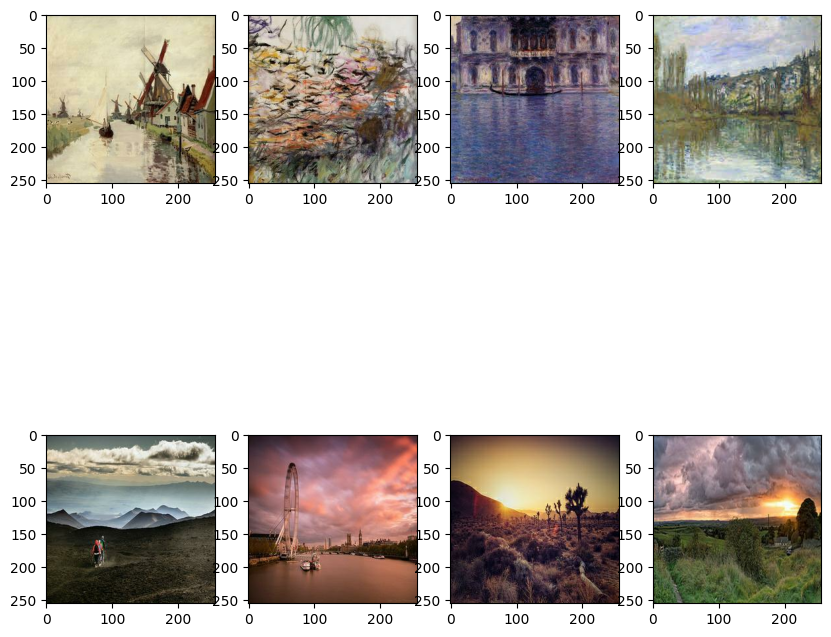

In [33]:
plt.figure(figsize=(10,10))

for i, img in enumerate(monet_ds.take(4)):
    plt.subplot(2,4,i+1)
    plt.imshow(img)

for i, img in enumerate(photo_ds.take(4)):
    plt.subplot(2,4,i+5)
    plt.imshow(img)

plt.show()

In [34]:
PHOTO_DATASET_SIZE = len(photo_ds)

train_size = int(0.8 * PHOTO_DATASET_SIZE)
test_size = int(0.2 * PHOTO_DATASET_SIZE)
BUFFER_SIZE = 1000

photo_ds = photo_ds.shuffle(BUFFER_SIZE)

train_photo_ds = photo_ds.take(train_size)

test_photo_ds = photo_ds.skip(train_size)
test_photo_ds = photo_ds.take(test_size)


# Monet
MONET_DATASET_SIZE = len(monet_ds)
BUFFER_SIZE = 1000

monet_ds = monet_ds.shuffle(BUFFER_SIZE)

train_monet_ds = monet_ds

Some helper functions process the real images and allow the generator to learn certain dimension aspects of the images. By storing as an array, color similarities and patterns within the images can be recognized and applied to the generated images.

Random crop and Random jitter are some image augmentation which helps to avoid overfitting by throwing some randomness into the learning process to help keep the generator honest. Visually, these processed images look enough like their category but are slightly "wonky."

In [35]:
IMG_HEIGHT = 320
IMG_WIDTH = 320
BATCH_SIZE = 3


def resize(image):
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    return image

# normalizing the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def denormalize(image):
    image = tf.cast(image, tf.float32)
    image = (image * 0.5 + 0.5) * 255 # Range 0 to 1 and then to range 0..255
    image = tf.cast(image, tf.int32)
    return image

def random_crop(image):
    cropped_image = tf.image.random_crop(
    image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
    return cropped_image

def random_jitter(image):
  # resizing to 350 x 350 x 3
    image = tf.image.resize(image, [350, 350],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = random_crop(image)
# random mirroring
    image = tf.image.random_flip_left_right(image)
    return image

def preprocess_image_train(image):
    image = resize(image)
    image = random_jitter(image)
    image = normalize(image)
    return image

def preprocess_image_test(image):
    image = resize(image)
    image = normalize(image)
    return image

In [36]:
train_photo_ds = train_photo_ds.map(
    preprocess_image_train).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_photo_ds = test_photo_ds.map(
    preprocess_image_test).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_monet_ds = train_monet_ds.map(
    preprocess_image_train).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

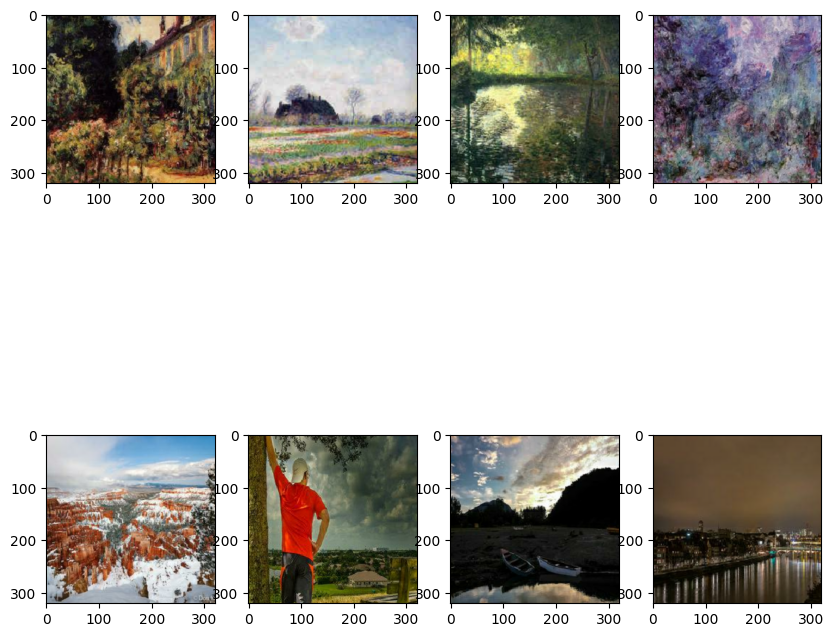

In [37]:
plt.figure(figsize=(10,10))

for i, img in enumerate(train_monet_ds.take(4)):
    plt.subplot(2,4,i+1)
    plt.imshow(denormalize(img[0,...]), vmin=0, vmax=255) # first dimension (batch) is eliminated and we denormalize the image

for i, img in enumerate(train_photo_ds.take(4)):
    plt.subplot(2,4,i+5)
    plt.imshow(denormalize(img[0,...]), vmin=0, vmax=255) # first dimension (batch) is eliminated and we denormalize the image

plt.show()


**Model Creation**

The generator - downsample function - and discriminator - upsample function - are created. The visuals provided help see the flow the images take for the generator to learn and the process which the random noise will undergo in order to create the artifical images.

A few loss functions are also defined to help the generator learn how far off from reality is through the process. These functions hope to minimize the difference between real and artification images at each step through the generator. This minimization helps keep the generator focused on the best possible - learning the content of the image while the domain may change from image to image.

Ultimately, only one epoch was able to run due to CPU limitations.

In [38]:
def downsample(filters, kernel_size=4, strides=2, apply_norm=True):
    result = keras.Sequential()
    initializer = tf.random_normal_initializer(0,0.02)

  # Convolutional layer
    result.add(layers.Conv2D(filters,
                    kernel_size=kernel_size,
                    strides=strides,
                    padding="same",
                    kernel_initializer=initializer,
                    use_bias=not apply_norm)) # when applying Normalization you already have the bias implicit

  # Normalization layer

  # Activation layer
    result.add(layers.LeakyReLU())

    return result

def upsample(filters, kernel_size=4, strides=2, apply_dropout=True):
    result = keras.Sequential()
    initializer = tf.random_normal_initializer(0,0.02)

  # Transpose convolutional layer
    result.add(layers.Conv2DTranspose(filters,
                            kernel_size=kernel_size,
                            strides=strides,
                            padding="same",
                            kernel_initializer=initializer,
                            use_bias=False)) # when applying BatchNormalization already has implicit bias

  # Normalization layer

  # Dropout layer
    if apply_dropout:
        result.add(layers.Dropout(0.5))

  # Activation layer
    result.add(layers.ReLU())

    return result

In [39]:
def Generator():

    inputs = layers.Input(shape=[IMG_HEIGHT,IMG_WIDTH,3])
    down_stack = [
                downsample(64, apply_norm=False),
                downsample(128),
                downsample(256),
                downsample(512),
                downsample(512),
                downsample(512),
                downsample(512, kernel_size=5, strides=5),
  ]

    up_stack = [
                upsample(512, kernel_size=5, strides=5),
                upsample(512),
                upsample(512, apply_dropout=False),
                upsample(256, apply_dropout=False),
                upsample(128, apply_dropout=False),
                upsample(64, apply_dropout=False),
  ]

  # Output layer
    initializer = tf.random_normal_initializer(0,0.02)
    last = layers.Conv2DTranspose(filters = 3, # Number of image channels
                                kernel_size=4,
                                strides=2,
                                padding="same",
                                kernel_initializer=initializer,
                                activation="tanh" # output -1 to 1
                                )

    x = inputs
    skips = []

  # We add the Encoder blocks to the model and save the outputs to later perform the Skip Connections
    for down in down_stack:
        x = down(x)
        skips.append(x)


  # We eliminate the last layer of the Skips Connections,
  # since it will be a direct input in the first block of the Decoder
  # and we turn the Skips around since the second layer must connect
  # with the penultimate output of the Encoder, the third with the penultimate .
  # and so on successively
    skips = reversed(skips[:-1])

  # We add the Decoder blocks to the model and sthe Skip Connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x,skip])
    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

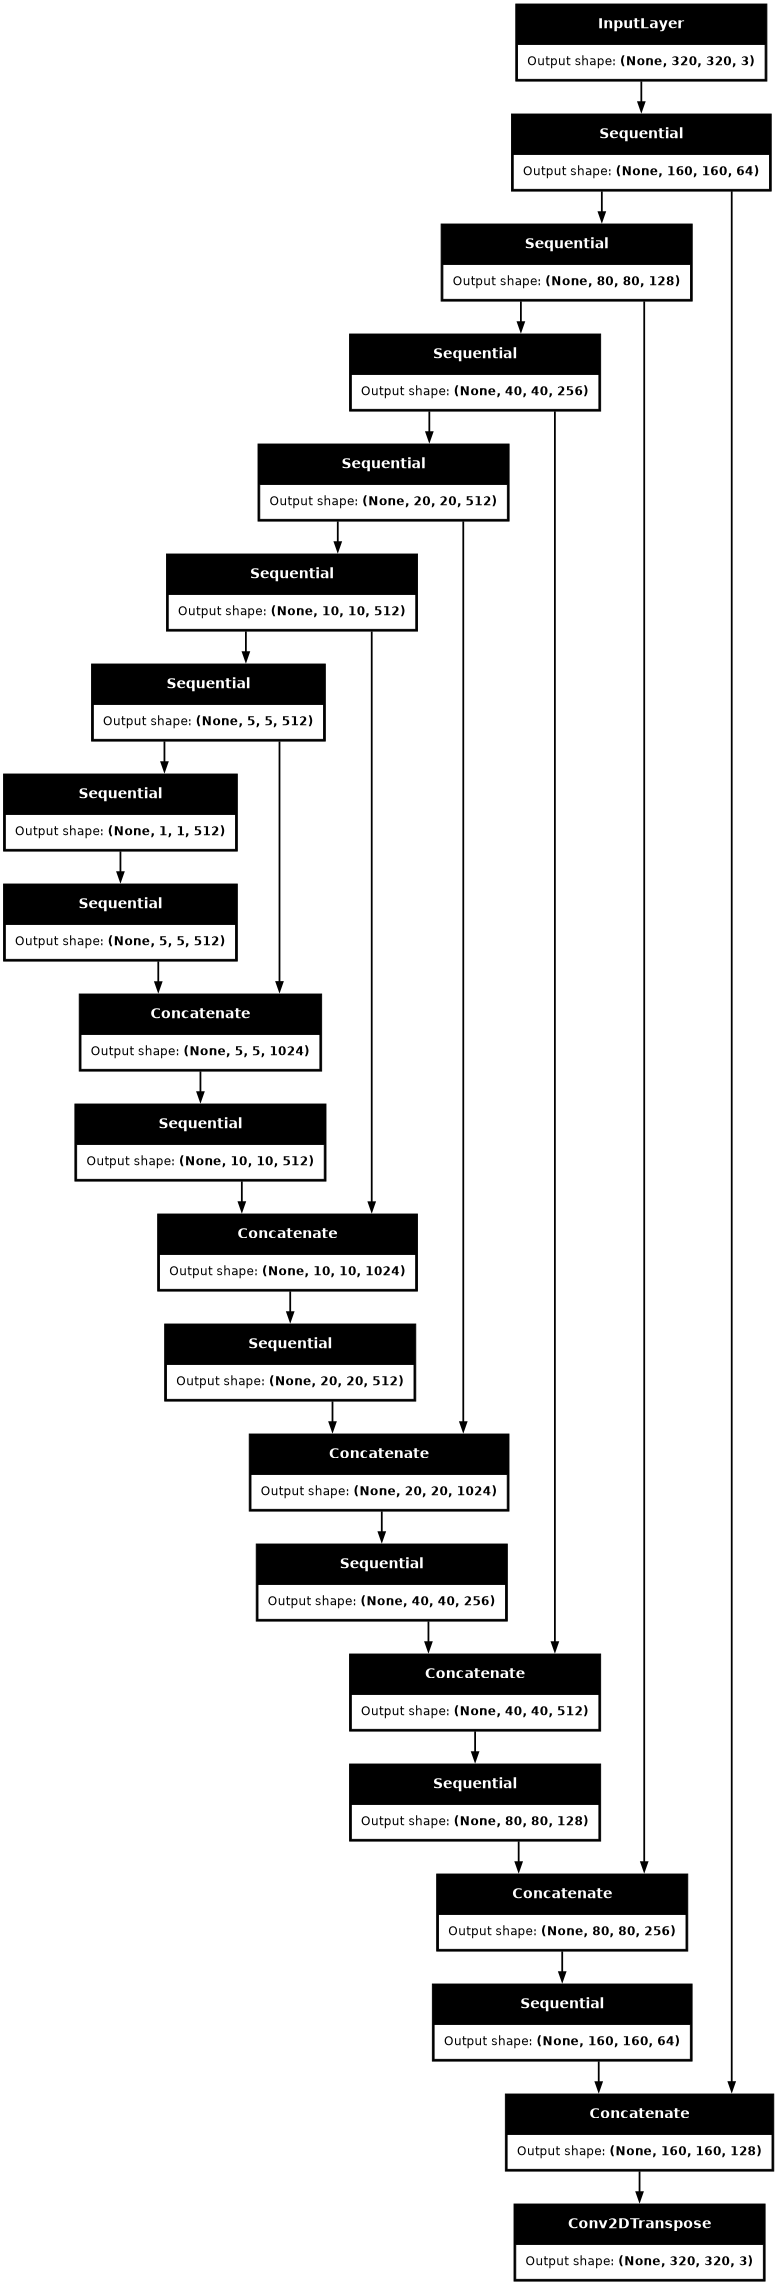

In [40]:
generator_g = Generator()
tf.keras.utils.plot_model(generator_g, show_shapes=True, dpi=64)

In [41]:
def Discriminator():

    ini = layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3], name="input_img")

    down1 = downsample(64, apply_norm=False)(ini)
    down2 = downsample(128)(down1)
    down3 = downsample(256)(down2)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)

    initializer = tf.random_normal_initializer(0., 0.02)
    conv = tf.keras.layers.Conv2D(512,
                                kernel_size=4,
                                strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)

    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    leaky_relu = tf.keras.layers.LeakyReLU()(conv)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

    last = tf.keras.layers.Conv2D(1,
                                kernel_size=4,
                                strides=1,
                                kernel_initializer=initializer)(zero_pad2)

    return keras.Model(inputs=ini, outputs=last)

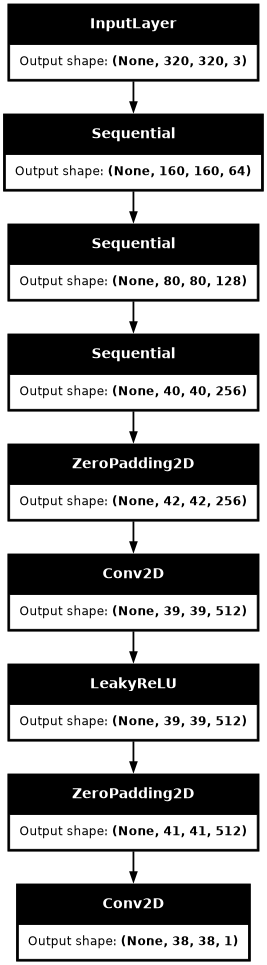

In [42]:
discriminator_y = Discriminator()
tf.keras.utils.plot_model(discriminator_y, show_shapes=True, dpi=64)

In [43]:
#with strategy.scope():
generator_monet = Generator()
generator_photo = Generator()

discriminator_monet = Discriminator()
discriminator_photo = Discriminator()

loss_object = keras.losses.BinaryCrossentropy(from_logits=True, 
                                              reduction=tf.keras.losses.Reduction.NONE)

In [44]:
#with strategy.scope():
def discriminator_loss(disc_real_output, disc_generated_output):
    #compare the real image with a matrix of 1. (All Ok)
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    #compare the fake image with a matrix of 0 (All Fake)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = (real_loss + generated_loss) / 2

    return total_disc_loss


In [45]:
#with strategy.scope():
def generator_adversarial_loss(disc_generated_output):
    return loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

#with strategy.scope():
def generator_calc_cycle_loss(real_image, cycled_image, param_lambda):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return param_lambda * loss1

#with strategy.scope():
def generator_identity_loss(real_image, same_image, param_lambda):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return param_lambda * 0.5 * loss

In [46]:
#with strategy.scope():
generator_monet_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5)
generator_photo_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5)

discriminator_monet_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5)
discriminator_photo_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5)

In [47]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_monet,
        generator_photo,
        discriminator_monet,
        discriminator_photo,
        lambda_cycle=10,
        lambda_identity=10
    ):
        super(CycleGan, self).__init__()
        self.generator_monet = generator_monet
        self.generator_photo = generator_photo
        self.discriminator_monet = discriminator_monet
        self.discriminator_photo = discriminator_photo
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity


    def compile(
        self,
        generator_monet_optimizer,
        generator_photo_optimizer,
        discriminator_monet_optimizer,
        discriminator_photo_optimizer,
        discriminator_loss,
        generator_adversarial_loss,
        generator_calc_cycle_loss,
        generator_identity_loss
    ):
        super(CycleGan, self).compile()
        self.generator_monet_optimizer = generator_monet_optimizer
        self.generator_photo_optimizer = generator_photo_optimizer
        self.discriminator_monet_optimizer = discriminator_monet_optimizer
        self.discriminator_photo_optimizer = discriminator_photo_optimizer
        self.discriminator_loss = discriminator_loss
        self.generator_adversarial_loss = generator_adversarial_loss
        self.generator_calc_cycle_loss = generator_calc_cycle_loss
        self.generator_identity_loss = generator_identity_loss



    def train_step(self, batch_data):

        monet, photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # Get Predictions
            # from photo we generate Monet (fake) and regenerate the photo again (cycle)
            gen_output_monet_fake = self.generator_monet(photo, training=False)
            gen_output_photo_cycle = self.generator_photo(gen_output_monet_fake, training=False)

            # from Monet we generate photo (fake) and regenerate Monet again (cycle)
            gen_output_photo_fake = self.generator_photo(monet, training=False)
            gen_output_monet_cycle = self.generator_monet(gen_output_photo_fake, training=False)

            # generating itself are used for identity loss.
            gen_output_monet_same = self.generator_monet(monet, training=False)
            gen_output_photo_same = self.generator_photo(photo, training=False)


            # Run the discriminator for real Monet (input) and generated Monet (fake)
            disc_out_monet_real = self.discriminator_monet(monet, training=False)
            disc_out_monet_fake = self.discriminator_monet(gen_output_monet_fake, training=False)

            # Run the discriminator for Real Photo (input) and Photo (fake)
            disc_out_photo_real = self.discriminator_photo(photo, training=False)
            disc_out_photo_fake = self.discriminator_photo(gen_output_photo_fake, training=False)

            # Calculate the loss
            gen_monet_adversarial_loss = self.generator_adversarial_loss(disc_out_monet_fake)
            gen_photo_adversarial_loss = self.generator_adversarial_loss(disc_out_photo_fake)

            # evaluates total cycle consistency loss
            total_cycle_loss = (self.generator_calc_cycle_loss(monet, gen_output_monet_cycle, self.lambda_cycle)
                                + self.generator_calc_cycle_loss(photo, gen_output_photo_cycle, self.lambda_cycle))

            gen_monet_identity_loss = self.generator_identity_loss(monet, gen_output_monet_same, self.lambda_identity)
            gen_photo_identity_loss = self.generator_identity_loss(photo, gen_output_photo_same, self.lambda_identity)

            # Total generator loss = adversarial loss + cycle loss + identity loss
            total_gen_monet_loss = (gen_monet_adversarial_loss + total_cycle_loss + gen_monet_identity_loss)
            total_gen_photo_loss = (gen_photo_adversarial_loss + total_cycle_loss + gen_photo_identity_loss)


            disc_monet_loss = self.discriminator_loss(disc_out_monet_real, disc_out_monet_fake)
            disc_photo_loss = self.discriminator_loss(disc_out_photo_real, disc_out_photo_fake)


        # Calculate the gradients for generator and discriminator
        gen_monet_gradients = tape.gradient(total_gen_monet_loss,
                                            self.generator_monet.trainable_variables)
        gen_photo_gradients = tape.gradient(total_gen_photo_loss,
                                            self.generator_photo.trainable_variables)


        disc_monet_gradients = tape.gradient(disc_monet_loss,
                                                self.discriminator_monet.trainable_variables)
        disc_photo_gradients = tape.gradient(disc_photo_loss,
                                               self.discriminator_photo.trainable_variables)

        # Apply the gradients to the optimizer


        self.generator_monet_optimizer.apply_gradients(zip(gen_monet_gradients,
                                                      self.generator_monet.trainable_variables))
        self.generator_photo_optimizer.apply_gradients(zip(gen_photo_gradients,
                                                     self.generator_photo.trainable_variables))

        self.discriminator_monet_optimizer.apply_gradients(zip(disc_monet_gradients,
                                                         self.discriminator_monet.trainable_variables))
        self.discriminator_photo_optimizer.apply_gradients(zip(disc_photo_gradients,
                                                        self.discriminator_photo.trainable_variables))

        return {
            "total_gen_monet_loss": total_gen_monet_loss,
            "total_gen_photo_loss": total_gen_photo_loss,
            "disc_monet_loss": disc_monet_loss,
            "disc_photo_loss": disc_photo_loss }

In [48]:
#with strategy.scope():
cycle_gan_model = CycleGan(
      generator_monet, generator_photo, discriminator_monet, discriminator_photo
  )

cycle_gan_model.compile(
      generator_monet_optimizer = generator_monet_optimizer,
      generator_photo_optimizer = generator_photo_optimizer,
      discriminator_monet_optimizer = discriminator_monet_optimizer,
      discriminator_photo_optimizer = discriminator_photo_optimizer,
      discriminator_loss = discriminator_loss,
      generator_adversarial_loss = generator_adversarial_loss,
      generator_calc_cycle_loss = generator_calc_cycle_loss,
      generator_identity_loss = generator_identity_loss
  )

In [49]:
mod = cycle_gan_model.fit(
    tf.data.Dataset.zip((train_photo_ds, train_monet_ds)),
    epochs=1,
)

34/34 ━━━━━━━━━━━━━━━━━━━━ 554s 16s/step - disc_monet_loss: 0.9432 - disc_photo_loss: 0.7361 - total_gen_monet_loss: 7.4816 - total_gen_photo_loss: 7.4353 - loss: 0.0000e+00


**Model Evaluation**

The GAN model was sucessful in running and creating a Monet-style image as demonstrated below.

Images for the contest were created but an unknown error prohibited submission. The submission could not find the zip file created.

In [50]:
def generate_images(model, test_input):
    prediction = model(test_input)

    plt.figure(figsize=(12, 12))

    plt.subplot(1, 2, 1)
    plt.imshow(test_input[0] * 0.5 + 0.5)
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(prediction[0] * 0.5 + 0.5)
    plt.title('Predicted Image')
    plt.axis('off')

    plt.show()

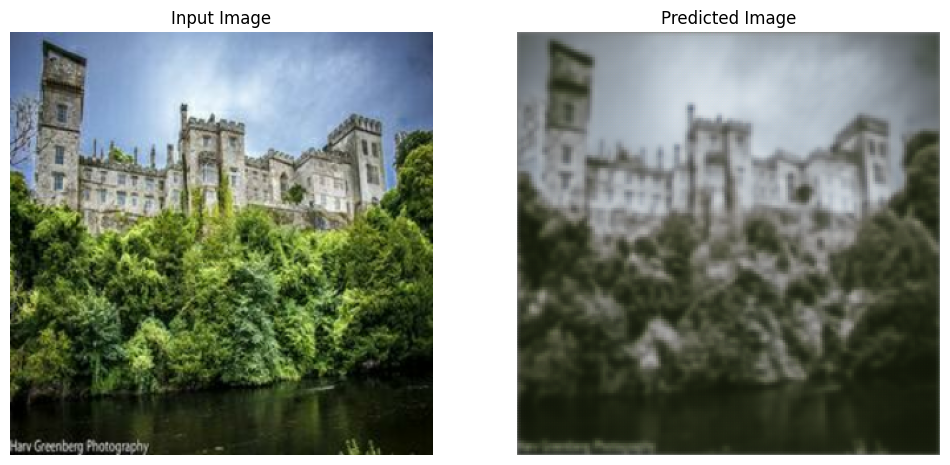

In [51]:
# Assuming 'test_photo_ds' yields images of shape (320, 320, 3)
image = next(iter(test_photo_ds))

# Ensure the image is of shape (320, 320, 3) and add a batch dimension
# Now 'image_batch' has the correct shape for the model
generate_images(generator_monet, image)

In [52]:
import PIL
! mkdir -p ../images

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [53]:
i = 1
photo_ds = tf.data.Dataset.list_files(str(GCS_PATH + '/photo_jpg/*.jpg')).map(load).take(7038)
pre_processed_photo_ds = photo_ds.map(
    preprocess_image_train).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

for img in pre_processed_photo_ds:
    prediction = generator_monet(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [54]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

As you can see, an output file is created using the set up from the example notebook provided in the competition.  PLEASE HELP.